# Model 3: ResNet50 Transfer Learning
## Pneumonia Classification with 3-Fold Cross-Validation + Ensemble Prediction

**Architecture:** ResNet50 pretrained (ImageNet) with partial fine-tuning
- Phase 1: Backbone frozen, train head (LR=1e-3)
- Phase 2: Unfreeze conv5_x block only (LR=1e-5)

**Optimizations:** 128×128 images, batch=8, mixed precision

**Ensemble Strategy:** Average predictions from all 3 folds

## 1. Setup & Configuration

In [2]:
import os, time, json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve
import warnings; warnings.filterwarnings('ignore')

print(f'TensorFlow: {tf.__version__}')
print(f'GPU: {tf.config.list_physical_devices("GPU")}')

TensorFlow: 2.10.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. GPU Memory Configuration

In [3]:
# GPU Config
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"Memory growth enabled for {len(gpus)} GPU(s)")

tf.keras.mixed_precision.set_global_policy('mixed_float16')
print(f'Mixed precision: {tf.keras.mixed_precision.global_policy()}')

Memory growth enabled for 1 GPU(s)
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6
Mixed precision: <Policy "mixed_float16">


## 3. Configuration Parameters

In [4]:
# Config
BASE_DIR = Path('chest_xray')
TRAIN_DIR, VAL_DIR, TEST_DIR = BASE_DIR/'train', BASE_DIR/'val', BASE_DIR/'test'
IMG_SIZE, BATCH_SIZE = 128, 8
EPOCHS_P1, EPOCHS_P2, N_FOLDS, PATIENCE = 10, 10, 3, 5
RANDOM_STATE = 42
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']
CLASS_MAP = {'NORMAL': 0, 'PNEUMONIA': 1}

print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Phase 1 Epochs: {EPOCHS_P1}, Phase 2 Epochs: {EPOCHS_P2}")
print(f"CV Folds: {N_FOLDS}")

Image Size: 128x128
Batch Size: 8
Phase 1 Epochs: 10, Phase 2 Epochs: 10
CV Folds: 3


## 4. Data Loading

In [5]:
# Load data
def load_data_paths(dirs):
    paths, labels = [], []
    for d in dirs:
        for cn in CLASS_NAMES:
            cd = d / cn
            if cd.exists():
                for p in cd.glob('*'):
                    if p.suffix.lower() in ['.jpeg','.jpg','.png']:
                        paths.append(str(p)); labels.append(CLASS_MAP[cn])
    return np.array(paths), np.array(labels)

train_val_paths, train_val_labels = load_data_paths([TRAIN_DIR, VAL_DIR])
test_paths, test_labels = load_data_paths([TEST_DIR])

print(f'Train+Val: {len(train_val_paths)} images')
print(f'  - Normal: {np.sum(train_val_labels == 0)}')
print(f'  - Pneumonia: {np.sum(train_val_labels == 1)}')
print(f'Test: {len(test_paths)} images')

Train+Val: 5232 images
  - Normal: 1349
  - Pneumonia: 3883
Test: 624 images


## 5. Data Preprocessing & Augmentation

In [6]:
# Dataset
def create_dataset(paths, labels, bs, augment=False, shuffle=True):
    def load_img(p, l):
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        return preprocess_input(img), l
    
    def aug(img, l):
        img = tf.image.random_brightness(img, 25.5)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        cs = tf.random.uniform([], int(IMG_SIZE*0.85), IMG_SIZE, dtype=tf.int32)
        img = tf.image.random_crop(img, [cs, cs, 3])
        return tf.image.resize(img, [IMG_SIZE, IMG_SIZE]), l
    
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle: ds = ds.shuffle(len(paths), seed=RANDOM_STATE)
    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    if augment: ds = ds.map(aug, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(bs).prefetch(tf.data.AUTOTUNE)

print("Dataset functions defined.")

Dataset functions defined.


## 6. ResNet50 Model Architecture

In [7]:
# Model
def create_resnet50(trainable=False):
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    base.trainable = trainable
    inp = keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    return keras.Model(inp, out), base

def unfreeze_conv5(base):
    base.trainable = True
    for l in base.layers:
        l.trainable = 'conv5' in l.name

model, base = create_resnet50()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128)               0     

## 7. Training with 3-Fold Cross-Validation (Two-Phase Fine-tuning)

In [8]:
# Class weights
cw_arr = compute_class_weight('balanced', classes=np.unique(train_val_labels), y=train_val_labels)
class_weights = {i: w for i, w in enumerate(cw_arr)}
print(f'Class weights: {class_weights}')

Class weights: {0: 1.939214232765011, 1: 0.6737058975019315}


In [9]:
# 3-Fold CV
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
fold_results, fold_histories = [], []
all_val_preds, all_val_labels = [], []
total_start = time.time()

for fold, (tr_idx, val_idx) in enumerate(skf.split(train_val_paths, train_val_labels)):
    print(f'\n{"="*50}\nFOLD {fold+1}/{N_FOLDS}\n{"="*50}')
    fold_start = time.time()
    
    X_tr, X_val = train_val_paths[tr_idx], train_val_paths[val_idx]
    y_tr, y_val = train_val_labels[tr_idx], train_val_labels[val_idx]
    
    print(f"Training samples: {len(X_tr)}")
    print(f"Validation samples: {len(X_val)}")
    
    train_ds = create_dataset(X_tr, y_tr, BATCH_SIZE, augment=True)
    val_ds = create_dataset(X_val, y_val, BATCH_SIZE, augment=False, shuffle=False)
    
    tf.keras.backend.clear_session()
    model, base = create_resnet50()
    
    # Phase 1: Train head only
    print("\n--- Phase 1: Training head (backbone frozen) ---")
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.AUC(name='auc')])
    cb1 = [callbacks.EarlyStopping('val_loss', patience=PATIENCE, restore_best_weights=True),
           callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=3, min_lr=1e-7)]
    h1 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_P1, class_weight=class_weights,
                   callbacks=cb1, verbose=1)
    
    # Phase 2: Fine-tune conv5_x block
    print("\n--- Phase 2: Fine-tuning conv5_x block ---")
    unfreeze_conv5(base)
    model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.AUC(name='auc')])
    cb2 = [callbacks.EarlyStopping('val_loss', patience=PATIENCE, restore_best_weights=True),
           callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=3, min_lr=1e-7)]
    h2 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_P2, class_weight=class_weights,
                   callbacks=cb2, verbose=1)
    
    # Combine histories
    hist = {k: h1.history[k]+h2.history[k] for k in h1.history}
    fold_histories.append(hist)
    
    # Evaluate
    preds_p = model.predict(val_ds, verbose=0)
    preds = (preds_p>0.5).astype(int).flatten()
    all_val_preds.extend(preds)
    all_val_labels.extend(y_val)
    
    acc, auc, prec, rec, f1 = (accuracy_score(y_val,preds), roc_auc_score(y_val,preds_p),
                               precision_score(y_val,preds), recall_score(y_val,preds), f1_score(y_val,preds))
    ft = time.time()-fold_start
    
    fold_results.append({'fold':fold+1,'accuracy':acc,'auc':auc,'precision':prec,'recall':rec,'f1':f1,'time':ft})
    print(f'\nFold {fold+1} Results: Acc:{acc:.4f} AUC:{auc:.4f} F1:{f1:.4f} Time:{ft/60:.1f}min')
    
    model.save(f'model_3_resnet50_fold_{fold+1}.keras')
    print(f'Model saved: model_3_resnet50_fold_{fold+1}.keras')

total_time = time.time()-total_start
print(f'\n{"="*60}\nTOTAL TIME: {total_time/60:.2f} min\n{"="*60}')


FOLD 1/3
Training samples: 3488
Validation samples: 1744

--- Phase 1: Training head (backbone frozen) ---
Epoch 1/10
436/436 [==============================] - 27s 40ms/step - loss: 0.3187 - accuracy: 0.8684 - auc: 0.9484 - val_loss: 0.1993 - val_accuracy: 0.9341 - val_auc: 0.9932 - lr: 0.0010
Epoch 2/10
436/436 [==============================] - 16s 36ms/step - loss: 0.2454 - accuracy: 0.9077 - auc: 0.9712 - val_loss: 0.1794 - val_accuracy: 0.9421 - val_auc: 0.9945 - lr: 0.0010
Epoch 3/10
436/436 [==============================] - 17s 38ms/step - loss: 0.2441 - accuracy: 0.9074 - auc: 0.9720 - val_loss: 0.1421 - val_accuracy: 0.9541 - val_auc: 0.9941 - lr: 0.0010
Epoch 4/10
436/436 [==============================] - 15s 33ms/step - loss: 0.2143 - accuracy: 0.9257 - auc: 0.9795 - val_loss: 0.1859 - val_accuracy: 0.9409 - val_auc: 0.9949 - lr: 0.0010
Epoch 5/10
436/436 [==============================] - 16s 37ms/step - loss: 0.2070 - accuracy: 0.9332 - auc: 0.9810 - val_loss: 0.2515 -

## 8. Training Curves Visualization

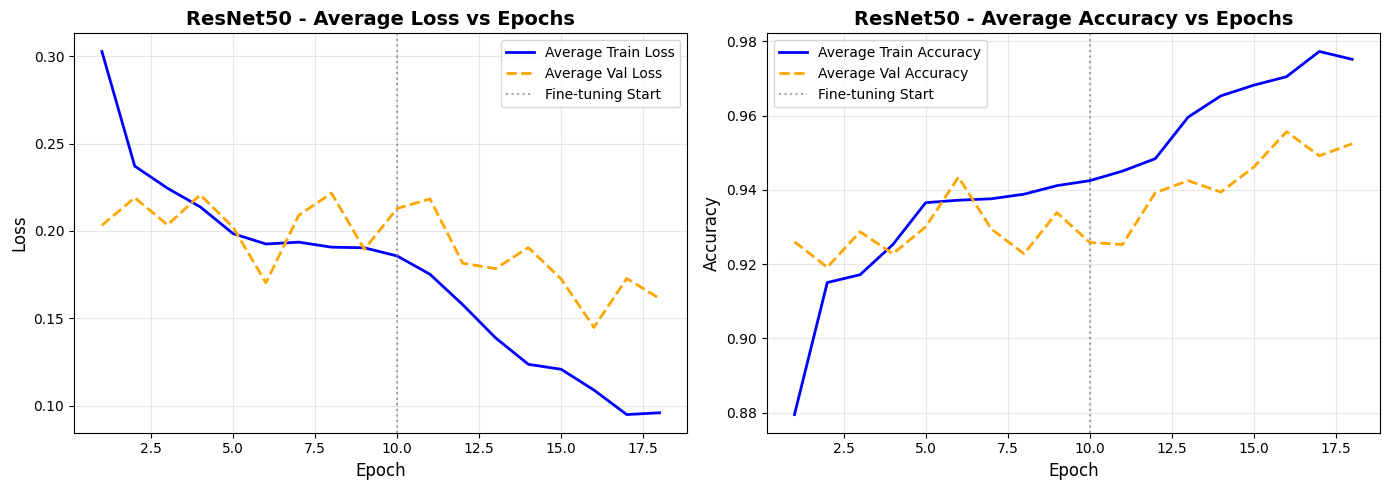

In [10]:
# Plot Average Loss & Accuracy curves
def get_avg_history(histories, metric):
    min_len = min([len(h[metric]) for h in histories])
    values = [h[metric][:min_len] for h in histories]
    return np.mean(values, axis=0), range(1, min_len+1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
avg_loss, eps = get_avg_history(fold_histories, 'loss')
avg_val_loss, _ = get_avg_history(fold_histories, 'val_loss')
axes[0].plot(eps, avg_loss, label='Average Train Loss', linewidth=2, color='blue')
axes[0].plot(eps, avg_val_loss, '--', label='Average Val Loss', linewidth=2, color='orange')
axes[0].axvline(x=EPOCHS_P1, color='gray', linestyle=':', alpha=0.7, label='Fine-tuning Start')
axes[0].set_xlabel('Epoch', fontsize=12); axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('ResNet50 - Average Loss vs Epochs', fontsize=14, fontweight='bold')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Accuracy
avg_acc, _ = get_avg_history(fold_histories, 'accuracy')
avg_val_acc, _ = get_avg_history(fold_histories, 'val_accuracy')
axes[1].plot(eps, avg_acc, label='Average Train Accuracy', linewidth=2, color='blue')
axes[1].plot(eps, avg_val_acc, '--', label='Average Val Accuracy', linewidth=2, color='orange')
axes[1].axvline(x=EPOCHS_P1, color='gray', linestyle=':', alpha=0.7, label='Fine-tuning Start')
axes[1].set_xlabel('Epoch', fontsize=12); axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('ResNet50 - Average Accuracy vs Epochs', fontsize=14, fontweight='bold')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_3_resnet50_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

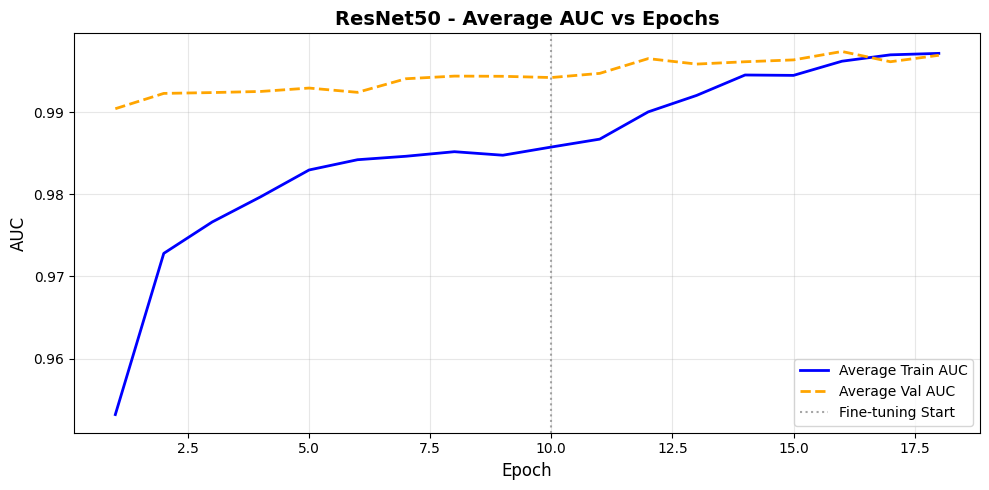

In [11]:
# Plot Average AUC curves
plt.figure(figsize=(10, 5))
avg_auc, eps = get_avg_history(fold_histories, 'auc')
avg_val_auc, _ = get_avg_history(fold_histories, 'val_auc')
plt.plot(eps, avg_auc, label='Average Train AUC', linewidth=2, color='blue')
plt.plot(eps, avg_val_auc, '--', label='Average Val AUC', linewidth=2, color='orange')
plt.axvline(x=EPOCHS_P1, color='gray', linestyle=':', alpha=0.7, label='Fine-tuning Start')
plt.xlabel('Epoch', fontsize=12); plt.ylabel('AUC', fontsize=12)
plt.title('ResNet50 - Average AUC vs Epochs', fontsize=14, fontweight='bold')
plt.legend(loc='lower right'); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_3_resnet50_auc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Cross-Validation Results Summary

In [12]:
# Results
df = pd.DataFrame(fold_results)
print('\n' + '='*60)
print('3-FOLD CROSS-VALIDATION RESULTS')
print('='*60)
print(df.to_string(index=False))

print('\n' + '-'*60)
print('AVERAGE METRICS (Mean ± Std)')
print('-'*60)
for m in ['accuracy','auc','precision','recall','f1']:
    print(f'{m.capitalize():12}: {df[m].mean():.4f} ± {df[m].std():.4f}')
print(f'\nTotal Training Time: {total_time/60:.2f} min')


3-FOLD CROSS-VALIDATION RESULTS
 fold  accuracy      auc  precision   recall       f1       time
    1  0.962156 0.998396   0.996764 0.952087 0.973913 350.397049
    2  0.959289 0.997688   0.997559 0.947450 0.971859 356.860326
    3  0.950688 0.997360   0.999174 0.934363 0.965682 362.710443

------------------------------------------------------------
AVERAGE METRICS (Mean ± Std)
------------------------------------------------------------
Accuracy    : 0.9574 ± 0.0060
Auc         : 0.9978 ± 0.0005
Precision   : 0.9978 ± 0.0012
Recall      : 0.9446 ± 0.0092
F1          : 0.9705 ± 0.0043

Total Training Time: 17.86 min


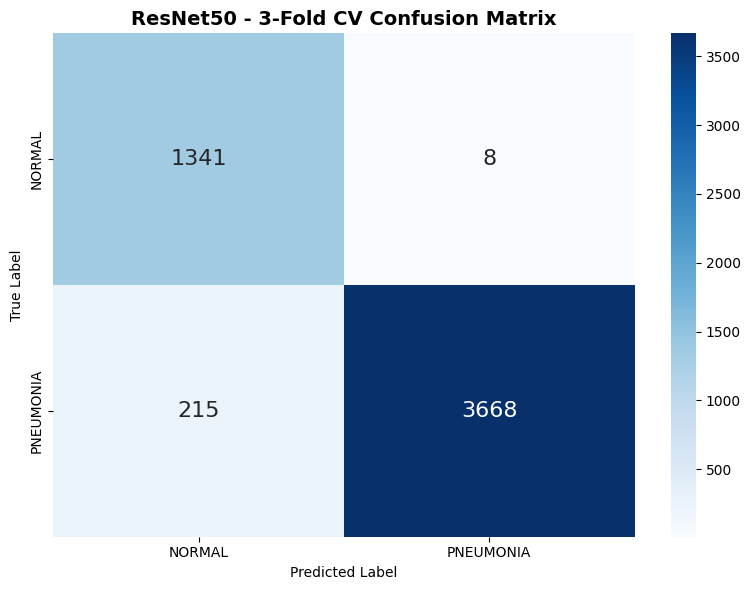


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.86      0.99      0.92      1349
   PNEUMONIA       1.00      0.94      0.97      3883

    accuracy                           0.96      5232
   macro avg       0.93      0.97      0.95      5232
weighted avg       0.96      0.96      0.96      5232



In [13]:
# CV Confusion Matrix
cm = confusion_matrix(all_val_labels, all_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            annot_kws={'size': 16})
plt.title('ResNet50 - 3-Fold CV Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('model_3_resnet50_cv_cm.png', dpi=150)
plt.show()

print('\nClassification Report:')
print(classification_report(all_val_labels, all_val_preds, target_names=CLASS_NAMES))

## 10. Ensemble Prediction on Test Set

**Strategy:** Load all 3 fold models, predict on test set, and average predictions for better robustness.

In [14]:
print("="*60)
print("ENSEMBLE PREDICTION - Loading all 3 fold models")
print("="*60)

# Load all 3 models
ensemble_models = []
for fold in range(1, N_FOLDS + 1):
    model_path = f'model_3_resnet50_fold_{fold}.keras'
    print(f"Loading {model_path}...")
    model = keras.models.load_model(model_path)
    ensemble_models.append(model)
print(f"\nLoaded {len(ensemble_models)} models for ensemble.")

ENSEMBLE PREDICTION - Loading all 3 fold models
Loading model_3_resnet50_fold_1.keras...
Loading model_3_resnet50_fold_2.keras...
Loading model_3_resnet50_fold_3.keras...

Loaded 3 models for ensemble.


In [15]:
# Create test dataset
test_ds = create_dataset(test_paths, test_labels, BATCH_SIZE, augment=False, shuffle=False)

# Predict with each model
print("\nMaking predictions with each model...")
all_test_preds = []
for i, model in enumerate(ensemble_models):
    print(f"  Predicting with Fold {i+1} model...")
    preds = model.predict(test_ds, verbose=0)
    all_test_preds.append(preds)
    print(f"    Mean prediction: {np.mean(preds):.4f}")

# Average predictions (Ensemble)
print("\nAveraging predictions from all 3 models...")
ensemble_preds_proba = np.mean(all_test_preds, axis=0)
ensemble_preds = (ensemble_preds_proba > 0.5).astype(int).flatten()

print(f"Ensemble mean prediction: {np.mean(ensemble_preds_proba):.4f}")


Making predictions with each model...
  Predicting with Fold 1 model...
    Mean prediction: 0.7029
  Predicting with Fold 2 model...
    Mean prediction: 0.6852
  Predicting with Fold 3 model...
    Mean prediction: 0.6671

Averaging predictions from all 3 models...
Ensemble mean prediction: 0.6851


In [16]:
# Calculate ensemble test metrics
test_acc = accuracy_score(test_labels, ensemble_preds)
test_auc = roc_auc_score(test_labels, ensemble_preds_proba)
test_prec = precision_score(test_labels, ensemble_preds)
test_rec = recall_score(test_labels, ensemble_preds)
test_f1 = f1_score(test_labels, ensemble_preds)

tn,fp,fn,tp = confusion_matrix(test_labels, ensemble_preds).ravel()
spec, sens = tn/(tn+fp), tp/(tp+fn)

print("\n" + "="*60)
print("ENSEMBLE TEST SET RESULTS")
print("="*60)
print(f'Accuracy:    {test_acc:.4f}')
print(f'AUC-ROC:     {test_auc:.4f}')
print(f'Precision:   {test_prec:.4f}')
print(f'Recall:      {test_rec:.4f}')
print(f'F1-Score:    {test_f1:.4f}')
print(f'Sensitivity: {sens:.4f} (Pneumonia detection)')
print(f'Specificity: {spec:.4f} (Normal detection)')


ENSEMBLE TEST SET RESULTS
Accuracy:    0.9199
AUC-ROC:     0.9757
Precision:   0.8991
Recall:      0.9821
F1-Score:    0.9387
Sensitivity: 0.9821 (Pneumonia detection)
Specificity: 0.8162 (Normal detection)


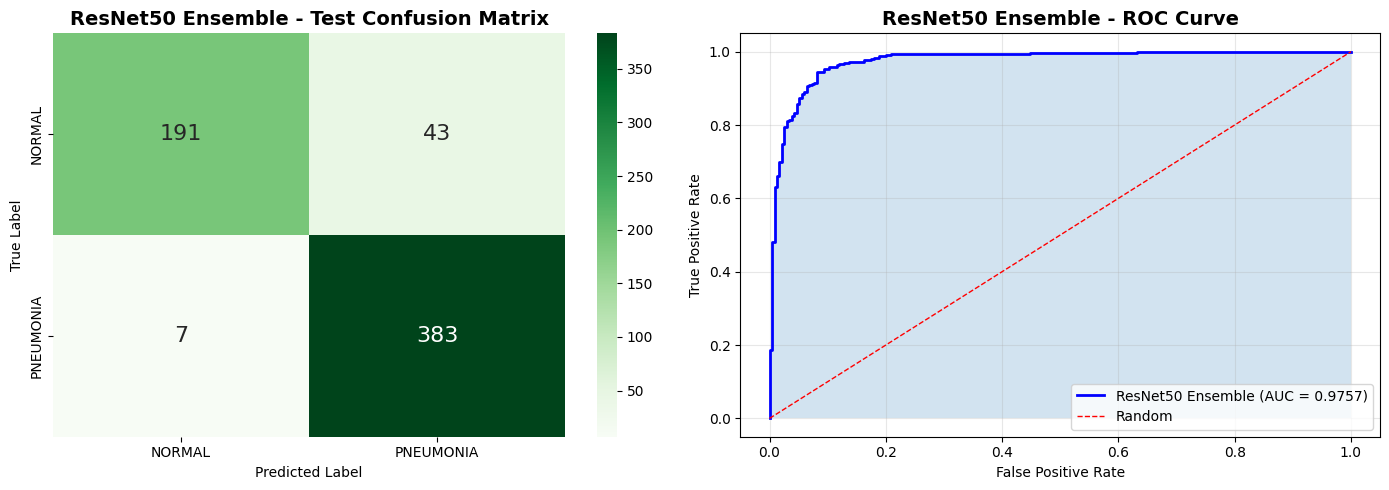


Test Classification Report (Ensemble):
              precision    recall  f1-score   support

      NORMAL       0.96      0.82      0.88       234
   PNEUMONIA       0.90      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



In [17]:
# Test Confusion Matrix + ROC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CM
cm_test = confusion_matrix(test_labels, ensemble_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[0], annot_kws={'size': 16})
axes[0].set_title('ResNet50 Ensemble - Test Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label'); axes[0].set_xlabel('Predicted Label')

# ROC
fpr, tpr, _ = roc_curve(test_labels, ensemble_preds_proba)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'ResNet50 Ensemble (AUC = {test_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
axes[1].fill_between(fpr, tpr, alpha=0.2)
axes[1].set_xlabel('False Positive Rate'); axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ResNet50 Ensemble - ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right'); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_3_resnet50_ensemble_test_results.png', dpi=150)
plt.show()

print('\nTest Classification Report (Ensemble):')
print(classification_report(test_labels, ensemble_preds, target_names=CLASS_NAMES))

## 11. Save Final Results

In [18]:
# Save
results = {
    'model': 'ResNet50 - Ensemble',
    'ensemble_strategy': 'Average predictions from 3 fold models',
    'total_time_min': total_time/60,
    'cv': {
        'accuracy_mean': float(df['accuracy'].mean()),
        'accuracy_std': float(df['accuracy'].std()),
        'auc_mean': float(df['auc'].mean()),
        'auc_std': float(df['auc'].std()),
        'f1_mean': float(df['f1'].mean()),
        'f1_std': float(df['f1'].std())
    },
    'test_ensemble': {
        'accuracy': float(test_acc),
        'auc': float(test_auc),
        'precision': float(test_prec),
        'recall': float(test_rec),
        'f1': float(test_f1),
        'sensitivity': float(sens),
        'specificity': float(spec)
    }
}

with open('model_3_resnet50_ensemble_results.json','w') as f:
    json.dump(results, f, indent=2)

print('Results saved to model_3_resnet50_ensemble_results.json')
print('\n' + '='*60)
print('MODEL 3: ResNet50 ENSEMBLE - COMPLETE')
print('='*60)

Results saved to model_3_resnet50_ensemble_results.json

MODEL 3: ResNet50 ENSEMBLE - COMPLETE
